## Data Exploration and Preliminary Analysis



In [3]:
#importing all the necessary libraries

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn import neighbors
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

In [4]:
#Reading the data and checking the shape

df = pd.read_csv('Admission_predict.csv')
print(df.shape)
df.head()

(500, 9)


,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,target
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


In [ ]:
#Resetting indexes, removing serial number column and getting the median of the target

df = df.reset_index(drop = True)
df = df.drop(columns = ['Serial No.'])
median_target = df.target.median()
print(median_target)
print(df.shape)
df.head()

In [ ]:
#Counting the number of values of target greater than the median of target
count_greater_median = (df.target > median_target).sum()
print(count_greater_median)


In [ ]:
#Converting target values greater than or equal to median as 1 and below median as 0

df['target_binary'] = (df['target'] >= median_target).astype(int)
df

In [ ]:
#isolating features and binary new target in seperate dataframe and series
features = df.iloc[:,:-2]
target = df.iloc[:,-1]
print(target)
print(features)

In [ ]:
#Splitting data using train test split and combining train data for seaborn plotting

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.3, random_state = 81)
df_train = pd.concat([X_train, y_train], axis = 1)
df_train.head()

### Effect of Standardization




In [ ]:
#plot 1: unstandardized data of CGPA vs GRE with hue of binary target

sns.lmplot(data = df_train, x = 'GRE Score', y = 'CGPA', hue = 'target_binary', palette = 'seismic')
plt.title('Unstandardized CGPA vs GRE Plot with Target Variable as different color')

In [ ]:
#Standardizing both GRE and CGPA by manual subtraction of mean and division by standard deviation

mean_GRE = df_train['GRE Score'].mean()
std_GRE = df_train['GRE Score'].std()
df_train['stdr_GRE'] = ((df_train['GRE Score'] - mean_GRE)/std_GRE)

mean_CGPA = df_train['CGPA'].mean()
std_CGPA = df_train['CGPA'].std()
df_train['stdr_CGPA'] = ((df_train['CGPA'] - mean_CGPA)/std_CGPA)
df_train.head()


In [ ]:
#plot 2: standardized data of CGPA vs GRE with hue of binary target

sns.lmplot(data = df_train, x = 'stdr_GRE', y = 'stdr_CGPA', hue = 'target_binary')


1. After standardization, the difference between the two graphs is only the scale of the axis that they are displayed on and both become very similar in terms of axis. Originally, GRE score and CGPA both had higher values of scales then after standardization. Otherwise, the spread and the class placement on the axis is the same for all data points.

2.  They look similar because seaborn automatically adjusted the original axis of both CGPA and GRE scores so that there range of each axis would only be as big as required to include all points. When we standardize, we subtract the same mean and divide by same standard deviation from all points. meaning that the inherent ratio of spread between each point does not change, and therefore their positions relative to each other do not change either. The only thing that actually occurs is that their values get scaled down to make it comparable.

3. With standardization, we can observe that the main benefit is that one particular feature with a bigger scale won't dominate the distance calculations in KNN, which could lead to less accuracy if other features are important in prediction as well. Therefore, by standardizing and bringing to similar scales, we allow for each feature to contribute similarly to the KNN distance based calculations.



## KNN Classifier without Standardization




In [ ]:
#Creating the knn function which loops over k of 1 to 100 over unstandardized train data and gets mean CV accuracy

def knn_unstandardized(X_train, y_train, number):
  train_accuracy = []
  test_accuracy = []
  k = []
  for i in range(1,number+1):
    knn = neighbors.KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    scores = cross_validate(knn, X_train, y_train, cv = 5, return_train_score = True)
    train_accuracy.append(scores['train_score'].mean())
    test_accuracy.append(scores['test_score'].mean())
    k.append(i)

  return k, train_accuracy, test_accuracy

In [ ]:
#Running function and combining results in a dataframe
k, train_accuracy, test_accuracy = knn_unstandardized(X_train,y_train, 100)
knn_unstandardized_df = pd.DataFrame({'k_value' : k, 'avg_train_accuracy': train_accuracy, 'avg_test_accuracy' : test_accuracy})
knn_unstandardized_df.head()

,k_value,avg_train_accuracy,avg_test_accuracy
0,1,1.000000,0.794286
1,2,0.904286,0.805714
2,3,0.896429,0.794286
3,4,0.873571,0.802857
4,5,0.861429,0.808571


In [ ]:
#Retrieving the row of the dataframe that has the maximum mean CV accuracy

knn_unstandardized_df.loc[knn_unstandardized_df.avg_test_accuracy == knn_unstandardized_df.avg_test_accuracy.max()]

,k_value,avg_train_accuracy,avg_test_accuracy
52,53,0.837857,0.837143





We see that perofrming knn from 1 to 100 neighbors and cross validating at each, we get the highest mean cross validation accuracy of 0.83714 or 83.714% at k = 53 neighbors

Text(0.5, 1.0, 'Average CV Accuracy (Train and Test) vs. k value')

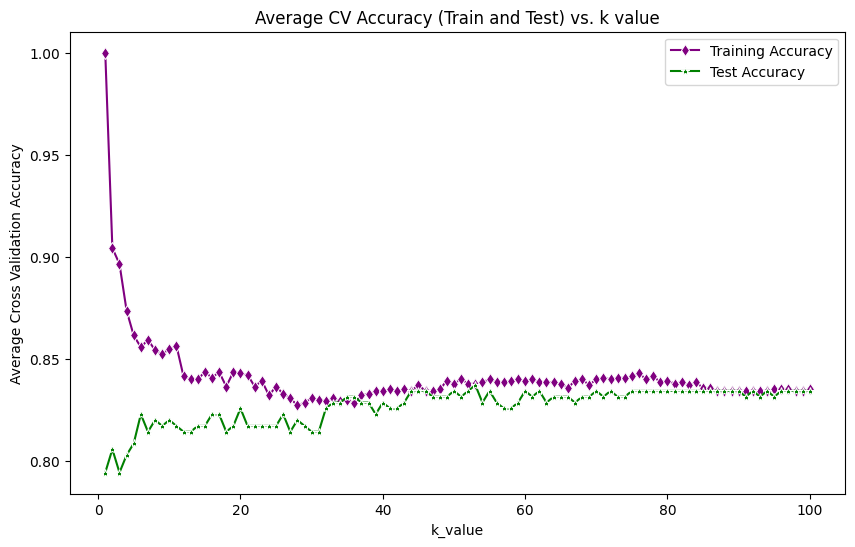

In [ ]:
#Plotting the training and testing accuracy curves to observe results and interpret overfitting and underfitting

plt.figure(figsize = (10,6))
sns.lineplot(data = knn_unstandardized_df, x = 'k_value', y = 'avg_train_accuracy', color = 'purple', marker = 'd', label = 'Training Accuracy')
sns.lineplot(data = knn_unstandardized_df, x = 'k_value', y = 'avg_test_accuracy', color = 'green', marker = '*', label = 'Test Accuracy')
plt.ylabel('Average Cross Validation Accuracy')
plt.title('Average CV Accuracy (Train and Test) vs. k value')



1. It is observed that from roughly around k = 1 to k = 32, the model is overfitting to the training data. This is the case because the training accuracy is higher in those ranges of k then the mean cross validation testing accuracy suggesting that data is learning the training data too well, causing it to not perform well on unseen data on average.

2. From ranges of after k = 53 to k = 100, the data seems to be slightly  underfitting, because both the training and the testing accuracy is comparatively poor compared to the best observed accuracy, suggesting the data is not capturing the complexity in the data enough and hence leading to slightly poorer test accuracy for both training and test data.

3. At k =53, we observe the best mean cross validation accuracy. The testing and training accuracy are close to each other and also not as low as after the ranges of k =53. However, the accuracy does not dip by too much after k = 53, but is still lower, suggesting some underfitting.

## Feature Selection








In [5]:
#Creating the feature selection function using DT Classifier

def Feature_selector(X_train , y_train , tr=0.95):
  best_all_test_accuracy = 0

  k_best = []
  best_test_accuracy = []
  no_of_features_remaining = []
  removed_feature = []
  features_remaining = []

  for i in range (1,101):
    knn = neighbors.KNeighborsClassifier(n_neighbors=i)
    scores = cross_validate(knn, X_train, y_train, cv = 5, return_train_score = True)

    if scores['test_score'].mean() > best_all_test_accuracy:
      best_all_test_accuracy = scores['test_score'].mean()
      k = i

  k_best.append(k)
  best_test_accuracy.append(best_all_test_accuracy)
  no_of_features_remaining.append(X_train.shape[1])

  dt = tree.DecisionTreeClassifier(random_state = 81)
  dt.fit(X_train,y_train)
  importance_series = pd.Series(dt.feature_importances_, index = X_train.columns)
  removed_feature.append('None')
  features_remaining.append(X_train.columns.tolist())

  while X_train.shape[1] > 1:

    least_importance_index = importance_series.idxmin()
    removed_feature.append(least_importance_index)
    X_train = X_train.drop(columns = least_importance_index)
    importance_series = importance_series.drop(least_importance_index)


    best_rem_feat_accuracy = 0

    for i in range(1,101):
      knn = neighbors.KNeighborsClassifier(n_neighbors = i)
      scores = cross_validate(knn, X_train, y_train, cv = 5, return_train_score = True)

      if scores['test_score'].mean() > best_rem_feat_accuracy:
        best_rem_feat_accuracy = scores['test_score'].mean()
        k = i

    k_best.append(k)
    best_test_accuracy.append(best_rem_feat_accuracy)
    no_of_features_remaining.append(X_train.shape[1])
    features_remaining.append(X_train.columns.tolist())

    if best_rem_feat_accuracy < tr*best_all_test_accuracy:
      break

  return k_best, best_test_accuracy, no_of_features_remaining, removed_feature, features_remaining

In [ ]:
#Running the feature selection on unstandardized data and creating a dataframe with results

k_best, best_test_accuracy, no_of_features_remaining, removed_feature, features_remaining = Feature_selector(X_train, y_train, tr = 0.95)

knn_df_2 = pd.DataFrame({'Best K Value' : k_best,
                         'Best Mean Test Accuracy' : best_test_accuracy,
                         'Number of Features Trained' : no_of_features_remaining,
                         'Features Removed' : removed_feature,
                         'Features Trained on':features_remaining})

knn_df_2

,Best K Value,Best Mean Test Accuracy,Number of Features Trained,Features Removed,Features Trained on
0,53,0.837143,7,None,"[GRE Score, TOEFL Score, University Rating, SO..."
1,46,0.840000,6,SOP,"[GRE Score, TOEFL Score, University Rating, LO..."
2,53,0.837143,5,University Rating,"[GRE Score, TOEFL Score, LOR, CGPA, Research]"
3,4,0.837143,4,LOR,"[GRE Score, TOEFL Score, CGPA, Research]"
4,4,0.837143,3,Research,"[GRE Score, TOEFL Score, CGPA]"
5,18,0.845714,2,TOEFL Score,"[GRE Score, CGPA]"
6,31,0.842857,1,GRE Score,[CGPA]


Text(0.5, 1.0, 'Best CV Mean Test Accuracy vs Features part of KNN Analysis')

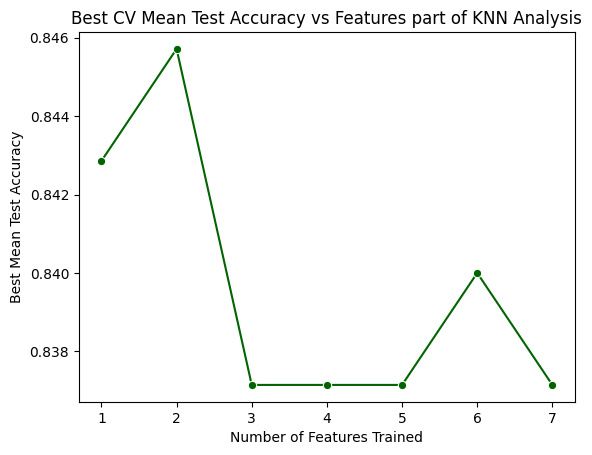

In [ ]:
#Plotting best mean CV accuracy vs number of features data trained on

sns.lineplot(data = knn_df_2, x = 'Number of Features Trained', y = 'Best Mean Test Accuracy', color = 'darkgreen', marker = 'o')
plt.title('Best CV Mean Test Accuracy vs Features part of KNN Analysis')

Text(0.5, 1.0, 'Best K Values vs Features part of KNN Analysis')

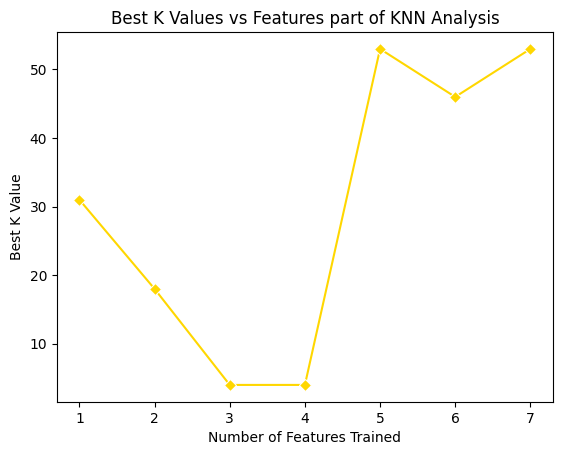

In [ ]:
#Plotting optimal k values (number of neighbors) vs number of features data was trained on

sns.lineplot(data = knn_df_2, x = 'Number of Features Trained' , y = 'Best K Value', color = 'gold', marker = 'D')
plt.title('Best K Values vs Features part of KNN Analysis')



*   Looking purely at the observed results, we can state that the number of features for essential classification are **2**. This is because we get the highest mean cross validation accuracy when we have 2 features remaining as shown by the first graph. Adding more features reduces the mean cross validation accuracy, suggesting that with more features, we are overfitting the data, causing it to perform worse as determined by the mean cross validation accuracy, as we could be introducing noise into the data with these additional features.

* One thing to understand is that the data is unstandardized, so even though essential number of features could be a different number, and it might not show as the data with higher feature values may dominate hiding how many features are actually relevant. Also, we are not considering all combinations of these features, but removing the one by one based on the decision tree classifiers importance, so its possible that a combination of more than 2 features, but a combination that is not examined here may have led to a higher mean CV accuracy.

* However, based on purely the observed results, we can say that the number of essential features for knn with unstandardized data is 2, because it yields the highest mean cross validation accuracy and with any more features we get worse performance, and with only 1 feature, we also get worse performance, because data may be underfitting by using just one feature.







## Model Performance using Standardization



In [ ]:
#Fitting standard scaler on training data and standardizing both training and test on this fitted standard scaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train_standardized = pd.DataFrame(scaler.transform(X_train), columns = X_train.columns.tolist())
X_test_standardized = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns.tolist())

In [ ]:
#Running feature selector function on standardized data, creating a dataframe with these results and combining with original unstandardized dataframe to plot the graphs
k_best_std, best_test_accuracy_std, no_of_features_remaining_std, removed_feature_std, features_remaining_std = Feature_selector(X_train_standardized, y_train, tr = 0.95)
knn_df_standardized = pd.DataFrame({'Best K Value_std' : k_best_std,
                                    'Best Mean Test Accuracy std' : best_test_accuracy_std,
                                    'Number of Features Trained std' : no_of_features_remaining_std,
                                    'Features Removed std' : removed_feature_std,
                                    'Features Remaining std': features_remaining_std})
combined_df = pd.concat([knn_df_2, knn_df_standardized], axis = 1)
combined_df

,Best K Value,Best Mean Test Accuracy,Number of Features Trained,Features Removed,Features Trained on,Best K Value_std,Best Mean Test Accuracy std,Number of Features Trained std,Features Removed std,Features Remaining std
0,53,0.837143,7,None,"[GRE Score, TOEFL Score, University Rating, SO...",10,0.871429,7,None,"[GRE Score, TOEFL Score, University Rating, SO..."
1,46,0.840000,6,SOP,"[GRE Score, TOEFL Score, University Rating, LO...",21,0.874286,6,SOP,"[GRE Score, TOEFL Score, University Rating, LO..."
2,53,0.837143,5,University Rating,"[GRE Score, TOEFL Score, LOR, CGPA, Research]",25,0.874286,5,University Rating,"[GRE Score, TOEFL Score, LOR, CGPA, Research]"
3,4,0.837143,4,LOR,"[GRE Score, TOEFL Score, CGPA, Research]",21,0.860000,4,LOR,"[GRE Score, TOEFL Score, CGPA, Research]"
4,4,0.837143,3,Research,"[GRE Score, TOEFL Score, CGPA]",21,0.865714,3,Research,"[GRE Score, TOEFL Score, CGPA]"
5,18,0.845714,2,TOEFL Score,"[GRE Score, CGPA]",40,0.865714,2,TOEFL Score,"[GRE Score, CGPA]"
6,31,0.842857,1,GRE Score,[CGPA],31,0.842857,1,GRE Score,[CGPA]


In [ ]:
#Obtaining the data correspoding with the highest mean CV test accuracy on the standardized data

combined_df.loc[combined_df['Best Mean Test Accuracy std'] == combined_df['Best Mean Test Accuracy std'].max()].iloc[:, 5:]

,Best K Value_std,Best Mean Test Accuracy std,Number of Features Trained std,Features Removed std,Features Remaining std
2,25,0.874286,5,University Rating,"[GRE Score, TOEFL Score, LOR, CGPA, Research]"


Text(0.5, 1.0, 'Standardized and Unstandardized Mean CV Test Score vs Number of Features Trained')

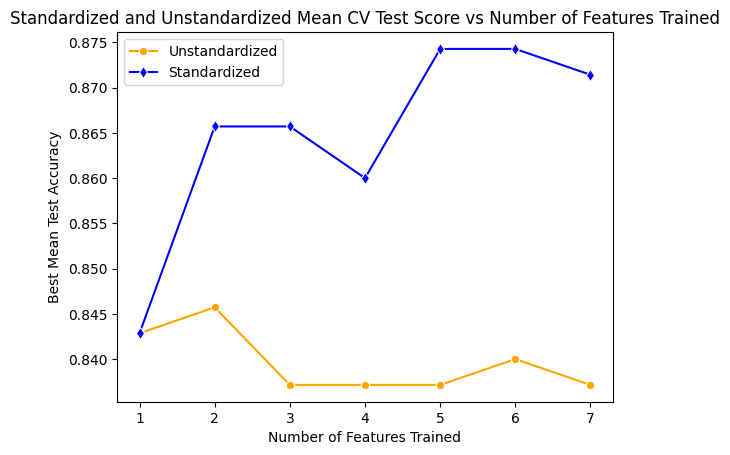

In [ ]:
#Plotting mean CV accuracy of standardized and unstandardized data on same graph

sns.lineplot(combined_df, x = 'Number of Features Trained', y = 'Best Mean Test Accuracy', color = 'Orange', label = 'Unstandardized', marker = 'o')
sns.lineplot(combined_df, x = 'Number of Features Trained', y = 'Best Mean Test Accuracy std', color = 'Blue', label = 'Standardized', marker = 'd')
plt.title('Standardized and Unstandardized Mean CV Test Score vs Number of Features Trained')


With standardization, we see an across the board improvement with more features in comparison to the unstandardized data for all number of features. With one feature the mean cross validation accuracy remains the same between the unstandardized and standardized data, but with more features, the standardized data has an improvement in accuracy for mean CV for standardized data.

The highest CV accuracy for standardized data is observed at 5 features with k = 25 , suggesting that all 5 features of GRE Score, TOEFL Score, LOR, CGPA and Research, are contributing towards improving a solution and is the optimal number of features for the model. Any lesser features may point towards underfitting as the model is learning less from less features while not performign as well on test data. With 7 features, the accuracy slightly reduces, suggesting that now the data is slightly overfitting with 7 features and therefore 5 features is optimal number of features in this case.

Standardization improves model accuracy as we now allow features that are actually important in predicting the target to contribute to the distance calculations allowing for better accuracy.



##Decision Tree Classifier


In [ ]:
#Creating the decision tree classifier to tune the max depth and minimum sample split

def decisiontreeclass(X_train_standardized, y_train, depth_range, sample_range):

  depth_value = []
  min_sample_value = []
  mean_test_accuracy = []

  for i in range(1,depth_range+1):
    for j in range(2,sample_range+1):
      tree = DecisionTreeClassifier(max_depth = i, min_samples_split = j, random_state = 81)
      scores = cross_validate(tree, X_train_standardized, y_train, cv = 5, return_train_score = True)
      depth_value.append(i)
      min_sample_value.append(j)
      mean_test_accuracy.append(scores['test_score'].mean())

  return depth_value, min_sample_value, mean_test_accuracy

In [ ]:
#Running the function, creating a dataframe and obtaining the parameters that give the highest mean cv accuracy

depth_value, min_sample_value, mean_test_accuracy = decisiontreeclass(X_train_standardized, y_train, 30, 30)

decision_tree_df = pd.DataFrame({'Maximum Depth' : depth_value,
                                 'Minimum Sample Value': min_sample_value,
                                 'Mean Best Test CV Accuracy' : mean_test_accuracy})

decision_tree_df.loc[decision_tree_df['Mean Best Test CV Accuracy'] == decision_tree_df['Mean Best Test CV Accuracy'].max()]

,Maximum Depth,Minimum Sample Value,Mean Best Test CV Accuracy
183,7,11,0.834286



With full feature standardized accuracy for KNN, we received the best Mean CV Accuracy as 87.14% with k = 10, while with tuned decision tree, we received the best full feature accuracy CV mean accuracy as 83.43% with maximum depth of 7 and minimum sample split of 11.

KNN outperforms decision tree for this dataset in terms of Mean CV accuracy of prediction of the binary target with full features

## Test Data


In [ ]:
#Fitting the KNN based on final optimal parameters, and the final selected features, and then calculating accuracy
#on the unseen test data set after dropping the irrelvant features from test data set

knn_final = neighbors.KNeighborsClassifier(n_neighbors = 25)
X_train_standardized_final = X_train_standardized.drop(columns = ['University Rating', 'SOP'])
knn_final.fit(X_train_standardized_final, y_train)
X_test_standardized_final = X_test_standardized.drop(columns = ['University Rating', 'SOP'])
accuracy = accuracy_score(y_test, knn_final.predict(X_test_standardized_final))
print ("Test set accuracy: ", accuracy * 100, "%")

Test set accuracy:  87.33333333333333 %


Our final KNN model with 5 features of GRE score, TOEFL Score, LOR, CGPA and Research with optimal k value of 25, gets accuaracy of 87.33% on the unseen 30% of test data.

This model accuracy is quite good for our KNN model as per industry standards, but an excellent accuracy would have been over 90%. But still 87.33% accuracy is very good for our KNN model.

 We see that the best mean cross validation scores of 87.428% on the standardized feature data, is very close to the observed accuracy of 87.33% on our test set data, indicating neither overfitting or underfitting over the training data, meaning the model generalizes well over the unseen test data, allowing for a robust model. Suggesting that we have tuned our knn model well.

References:

https://towardsdatascience.com/decision-trees-in-machine-learning-641b9c4e8052

https://www.analyticsvidhya.com/blog/2021/02/machine-learning-101-decision-tree-algorithm-for-classification/